# Workflows

In this example, we would like to present Roboflow workflows that make it possible to create ML logic without writing code. You can define workflow as a JSON document and run it in locally or using `inference` HTTP API (the latter will be demonstrated).

This feature is still in **alpha** preview - any feedback appreciated, although `wofkflows` already provide much more features that we present in this notebook - we highly encourage exploring other possibilities.

Docs are available [here](https://github.com/roboflow/inference/tree/main/inference/enterprise/workflows).

## Install External Dependancies

In this example, we'll use [Supervision](https://github.com/roboflow/supervision) to annotate an image with our inference results.

In [1]:
!pip install supervision==0.18.0

## Download required images

We need to pull images required for demos.

In [2]:
!wget https://media.roboflow.com/workflows_examples_images.zip

--2024-02-21 12:10:58--  https://media.roboflow.com/workflows_examples_images.zip
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8229834 (7.8M) [application/zip]
Saving to: ‘workflows_examples_images.zip’

workflows_examples_ 100%[===================>]   7.85M  8.77MB/s    in 0.9s    

2024-02-21 12:10:59 (8.77 MB/s) - ‘workflows_examples_images.zip’ saved [8229834/8229834]



In [3]:
!unzip workflows_examples_images.zip -d images

Archive:  workflows_examples_images.zip
  inflating: images/license_plate_1.jpg  
  inflating: images/__MACOSX/._license_plate_1.jpg  
  inflating: images/dogs_2.jpg       
  inflating: images/__MACOSX/._dogs_2.jpg  
  inflating: images/credits.txt      
  inflating: images/__MACOSX/._credits.txt  
  inflating: images/multiple_cars_3.jpg  
  inflating: images/__MACOSX/._multiple_cars_3.jpg  
  inflating: images/multiple_cars_2.jpg  
  inflating: images/__MACOSX/._multiple_cars_2.jpg  
  inflating: images/license_plate_2.jpg  
  inflating: images/__MACOSX/._license_plate_2.jpg  
  inflating: images/multiple_cars_1.jpg  
  inflating: images/__MACOSX/._multiple_cars_1.jpg  
  inflating: images/dogs_1.jpg       
  inflating: images/__MACOSX/._dogs_1.jpg  


In [4]:
!ls images

__MACOSX     dogs_2.jpg		  multiple_cars_1.jpg
credits.txt  license_plate_1.jpg  multiple_cars_2.jpg
dogs_1.jpg   license_plate_2.jpg  multiple_cars_3.jpg


### Roboflow API Key

To use `workflows`, you'll need a Roboflow API Key. Find instructions for retrieving your API key [here](https://docs.roboflow.com/api-reference/authentication). The utility function below attempts to load your Roboflow API key from your enviornment. If it isn't found, it then prompts you to input it. To avoid needing to input your API key for each example, you can configure your Roboflow API key in your environment via the variable `ROBOFLOW_API_KEY`.

In [5]:
from utils import get_roboflow_api_key

api_key = get_roboflow_api_key()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Roboflow API Key: ········


### Inference client

`inference_sdk` package has HTTP client capable to interact with `workflows`. Let's initialse the client.

In [6]:
import supervision as sv
import cv2
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient, VisualisationResponseFormat, InferenceConfiguration

In [49]:
CLIENT = InferenceHTTPClient(
    api_url="http://127.0.0.1:9001",
    api_key=api_key
)

# to ease visualisation, we will make the image outputs translated to np.array
CLIENT.configure(
    InferenceConfiguration(output_visualisation_format=VisualisationResponseFormat.NUMPY)
)

## Reading licence plates

In this example we will show how to combine object detection model with DocTR OCR model. 

Use-case is the following: we want to detect and recognise charactes from licence plates of cars visible in the footage. 

Our `workflow` uses [Unviverse model to detect licence plates](https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk/model/2) to get bounding boxes over
licence plates and then each bounding box is cropped from original image and submited into OCR model.

Refer [docs](https://github.com/roboflow/inference/tree/main/inference/enterprise/workflows) to discover `workflows` capabilities.

In [8]:
READING_PLATES_SPECIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },   # definition of input image
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",   # definition of object detection model
                "name": "plates_detector",  
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "vehicle-registration-plates-trudk/2",  # pointing model to be used
            },
             {
                "type": "DetectionOffset",  # DocTR model usually works better if there is slight padding around text to be detected - hence we are offseting predictions
                "name": "offset",
                "predictions": "$steps.plates_detector.predictions",  # reference to the object detection model output
                "offset_x": 200,  # value of offset
                "offset_y": 40,  # value of offset
            },
            {
                "type": "Crop",   # we would like to run OCR against each and every plate detected - hece we are cropping inputr image using offseted predictions
                "name": "cropping",
                "image": "$inputs.image",  # we need to point image to crop
                "detections": "$steps.offset.predictions",  # we need to point detections that will be used to crop image (in this case - we use offseted prediction)
            },        
            {
                "type": "OCRModel",  # we define OCR model
                "name": "step_ocr",
                "image": "$steps.cropping.crops",  # OCR model as an input takes a reference to crops that were created based on detections
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.plates_detector.predictions" },  # output with object detection model predictions
            { "type": "JsonField", "name": "image", "selector": "$steps.plates_detector.image" },  # output with image metadata - required by `supervision`
            { "type": "JsonField", "name": "recognised_plates", "selector": "$steps.step_ocr.result" },  # field that will retrieve OCR result
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" },  # crops that were made based on plates detections - used here just to ease visualisation
        ]   
    }
}

In [9]:
license_plate_image_1 = cv2.imread("./images/license_plate_1.jpg")
license_plate_image_2 = cv2.imread("./images/license_plate_2.jpg")

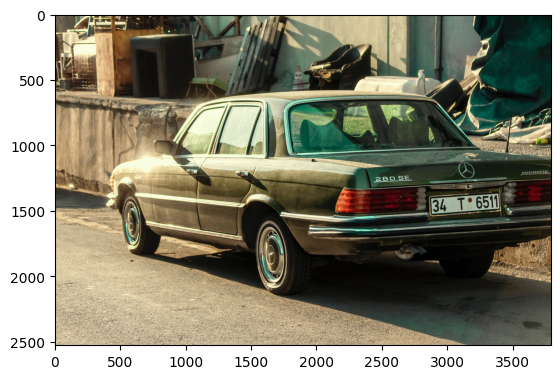

In [10]:
plt.imshow(license_plate_image_1[:, :, ::-1])
plt.show()

In [11]:
license_plate_result_1 = CLIENT.infer_from_workflow(
    specification=READING_PLATES_SPECIFICATION["specification"],
    images={"image": license_plate_image_1},
)

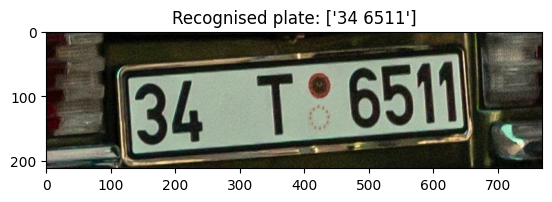

In [12]:
plt.title(f"Recognised plate: {license_plate_result_1['recognised_plates']}")
plt.imshow(license_plate_result_1["crops"][0]["value"][:, :, ::-1])
plt.show()

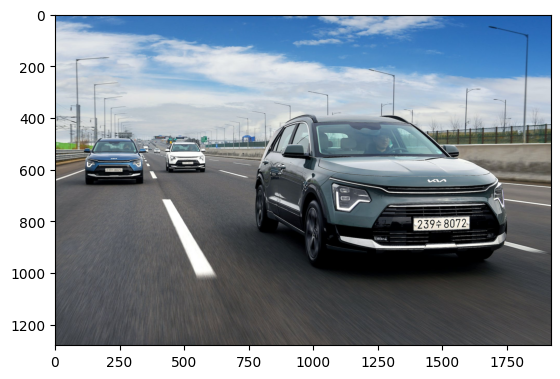

In [13]:
plt.imshow(license_plate_image_2[:, :, ::-1])
plt.show()

In [14]:
license_plate_result_2 = CLIENT.infer_from_workflow(
    specification=READING_PLATES_SPECIFICATION["specification"],
    images={"image": license_plate_image_2},
)

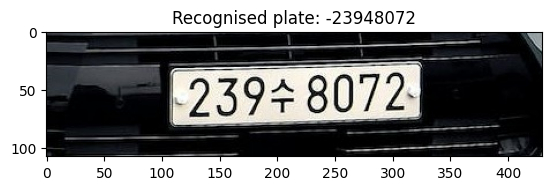

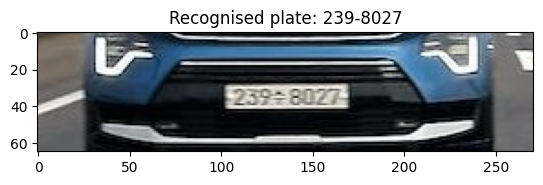

In [15]:
for i in range(len(license_plate_result_2["recognised_plates"])):
    plt.title(f"Recognised plate: {license_plate_result_2['recognised_plates'][i]}")
    plt.imshow(license_plate_result_2["crops"][i]["value"][:, :, ::-1])
    plt.show()

## Zero-shot image classification

In this example, we will show how to detect cars in the image and then classify type of the car. We will not use custom models trained on that task - instead we will combine standard `YOLOv8` model trained on COCO dataset with `Clip` model capable to
calculate similarity between image and text.

In [16]:
CAR_SPECS = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },   # definition of input image
            { "type": "InferenceParameter", "name": "car_types" },   # definition of parameter that is supposed to provide list of classes that CLIP should compare detections against - please note that this value is not hard-coded and can be changed each time you run workflow
            { "type": "InferenceParameter", "name": "detection_model", "default_value": "yolov8s-640" },  # definition of parameter that points object detection model - can be changed each time you run workflow, but has default value defined.
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",  # definition of object detection model
                "name": "detection",
                "image": "$inputs.image",   # linking input image into detection model
                "model_id": "$inputs.detection_model",  # pointing model to be used (via input parameter - can be overriden in runtime)
                "iou_threshold": 0.5,
                "class_filter": ["car", "truck"],  # specification of classes filter for a model
            },
            {
                "type": "Crop",  # we would like to run CLIP against each and every car / truck - hece we are cropping inputr image using predictions
                "name": "cropping",
                "image": "$inputs.image",  # we need to point image to crop
                "detections": "$steps.detection.predictions",  # we need to point detections that will be used to crop image
            },        
            {
                "type": "ClipComparison",  # definition of CLIP comparison step
                "name": "clip",
                "image": "$steps.cropping.crops",  # as an input we refer to crops that are created based on car / truck detections
                "text": "$inputs.car_types",  # this parameter specify CLIP query - list of classes that each crop will be compared to - in this case we refer to input parameter `car_types` - which will be provided later, when you run the workflow
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.detection.predictions" },  # output with object detection model predictions
            { "type": "JsonField", "name": "clip", "selector": "$steps.clip.similarity" },  # output with CLIP similarities
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" },  # crops that were made based on cars detections - used here just to ease visualisation
        ]  
    }
}

In [17]:
multiple_cars_image_1 = cv2.imread("./images/multiple_cars_1.jpg")
multiple_cars_image_3 = cv2.imread("./images/multiple_cars_3.jpg")

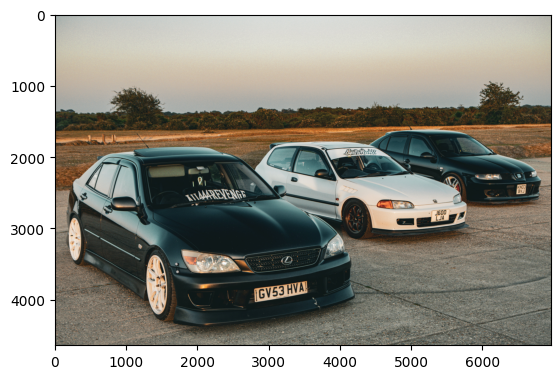

In [18]:
plt.imshow(multiple_cars_image_1[:, :, ::-1])
plt.show()

In [19]:
car_brands = ["Lexus", "Honda", "Seat"]
multiple_cars_result_1 = CLIENT.infer_from_workflow(
    specification=CAR_SPECS["specification"],
    images={"image": multiple_cars_image_1},
    parameters={"car_types": car_brands}  # we could place here `detection_model` to change model
)

In [20]:
import numpy as np

clip_predicted_classes_id = np.argmax(multiple_cars_result_1["clip"], axis=1)
clip_predicted_classes = [car_brands[class_id] for class_id in clip_predicted_classes_id]

We can see that first two cars were recognised correctly. The last one - was misclassified by Clip (possibly due to oclussion with Honda car)

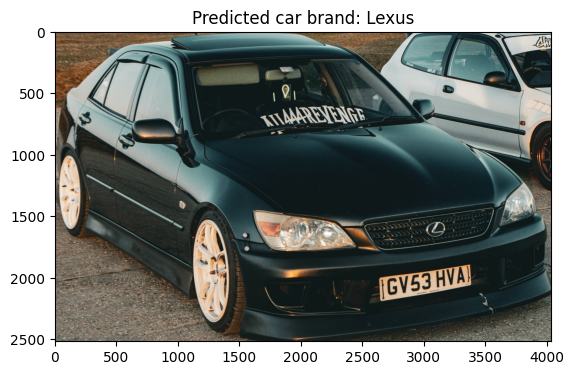

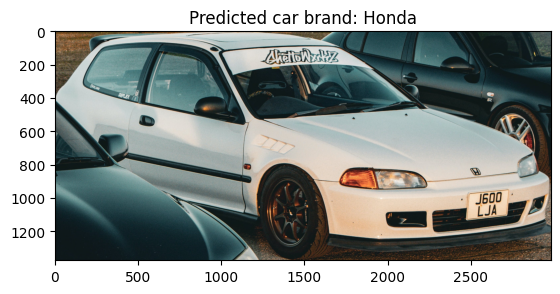

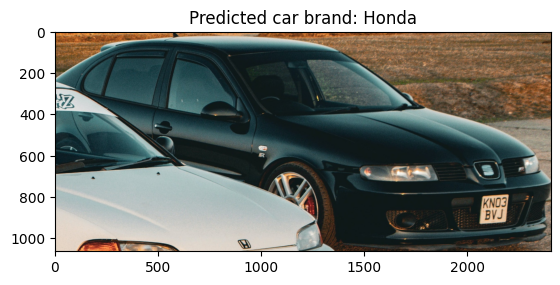

In [21]:
for predicted_class, crop in zip(clip_predicted_classes, multiple_cars_result_1["crops"]):
    crop_image = crop["value"]
    plt.title(f"Predicted car brand: {predicted_class}")
    plt.imshow(crop_image[:, :, ::-1])
    plt.show()

In [22]:
emergency_cars_types = ["ambulance", "fire truck"]

multiple_cars_result_3 = CLIENT.infer_from_workflow(
    specification=CAR_SPECS["specification"],
    images={"image": multiple_cars_image_3},
    parameters={"car_types": emergency_cars_types}   # please note that now we re-use the same workflow to run completedly different classification
)

In [23]:
clip_predicted_classes_id = np.argmax(multiple_cars_result_3["clip"], axis=1)
clip_predicted_classes = [emergency_cars_types[class_id] for class_id in clip_predicted_classes_id]

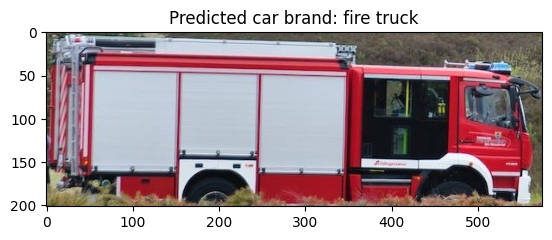

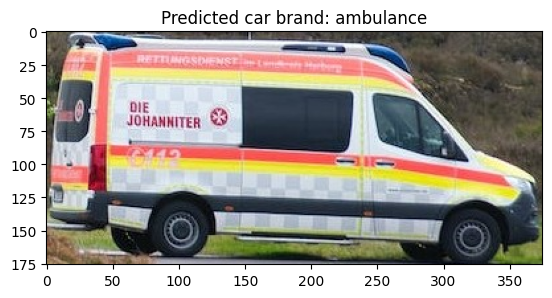

In [24]:
for predicted_class, crop in zip(clip_predicted_classes, multiple_cars_result_3["crops"]):
    crop_image = crop["value"]
    plt.title(f"Predicted car brand: {predicted_class}")
    plt.imshow(crop_image[:, :, ::-1])
    plt.show()

## Running multiple models in parallel and combining results

In this example, we will show how to easily combine predictions from different models. We will use YOLOv8 model to get predictions (classes defined in COCO). On top of that, we will run another model to get detections of car license plates.

In [25]:
MULTIPLE_MODELS_SPECIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },  # definition of input image
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",  # definition of first object detection model - generic detection based on COCO classes
                "name": "general_detection",
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "yolov8s-640",  # pointing model to be used
                "iou_threshold": 0.5,
            },
            {
                "type": "ObjectDetectionModel",  # definition of second object detection model - detection of plates
                "name": "plates_detection",
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "vehicle-registration-plates-trudk/2",  # pointing model to be used
            },
            {
                "type": "DetectionsConsensus",  # Definition of detections merge step
                "name": "fussion",
                "predictions": [  # here, we need to place the reference to all of detection steps outputs we want to merge - in thise case - we are merging 2 previously defined models
                    "$steps.general_detection.predictions",  
                    "$steps.plates_detection.predictions",
                ],
                "required_votes": 1,  # DetectionsConsensus step can be extensively configured to merge overlapping predictions from model ensemble. In this case, however, we use the simpliest possible configuration that will 
                # assume that object is present if at least one model predicts specific element
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.fussion.predictions" },  # output with combined predictions
            { "type": "JsonField", "name": "image", "selector": "$steps.fussion.image" },  # output with image metadata (required by `supervision`)
        ]   
    }
}

In [28]:
multiple_cars_image_2 = cv2.imread("./images/multiple_cars_2.jpg")

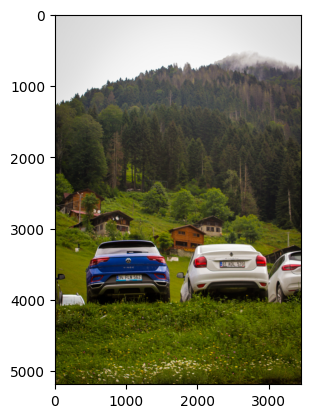

In [29]:
plt.imshow(multiple_cars_image_2[:, :, ::-1])
plt.show()

In [30]:
detection_coco_and_plates = CLIENT.infer_from_workflow(
    specification=MULTIPLE_MODELS_SPECIFICATION["specification"],
    images={"image": multiple_cars_image_2},
)

Output of `workflows` execution is compatible with `supervision` - we can easily use `supervision` visualisation tools to see that predictions from both models were combined

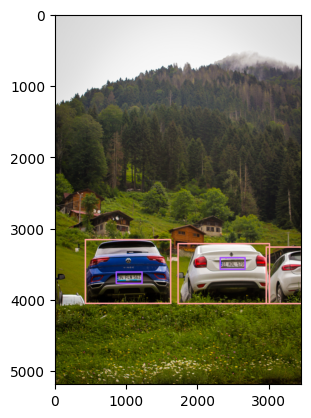

In [31]:
for predictions, image in zip(detection_coco_and_plates["predictions"], detection_coco_and_plates["image"]):
    annotator = sv.BoundingBoxAnnotator(thickness=20)
    detections = sv.Detections.from_inference({"predictions": predictions, "image": image})
    plt.imshow(annotator.annotate(multiple_cars_image_2.copy(), detections)[:, :, ::-1])
    plt.show()

## Detect generic classes and classify predictions using specialised model

In this example, we would like to present the use case when off-the-shelf model is used to detect objects of specific kind and then custom model is used to classify detections.
We would like to detect all `dogs` in the images and then use [Universe dog breed classifier](https://universe.roboflow.com/cian-zpr5u/dog-breed-xpaq6/dataset/1) to get detailed information about breeds.

In [32]:
DETECTION_PLUS_CLASSIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },   # definition of input image
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",  # definition of object detection model - generic detection based on COCO classes
                "name": "general_detection",
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "yolov8n-1280",  # pointing model to be used
                "class_filter": ["dog"]  # filtering classes of interest
            },
            {
                "type": "Crop",  # we would like to run specialised classification of dog breed based on each detected `dog` bounding box
                "name": "cropping",
                "image": "$inputs.image",  # linking input image into detection model
                "detections": "$steps.general_detection.predictions",  # we need to point detections that will be used to crop image
            },    
            {
                "type": "ClassificationModel",  # definition of classification model - specialised classifier of dogs breed
                "name": "breds_classification",
                "image": "$steps.cropping.crops",  # linking crops created based on dogs bounding boxes as input for classification
                "model_id": "dog-breed-xpaq6/1",  # pointing model to be used
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.breds_classification.top" },  # output with classification prediction
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" },  # crops that were made based on dogs detections - used here just to ease visualisation
        ]   
    }
}

In [33]:
dogs_image_1 = cv2.imread("./images/dogs_1.jpg")
dogs_image_2 = cv2.imread("./images/dogs_2.jpg")

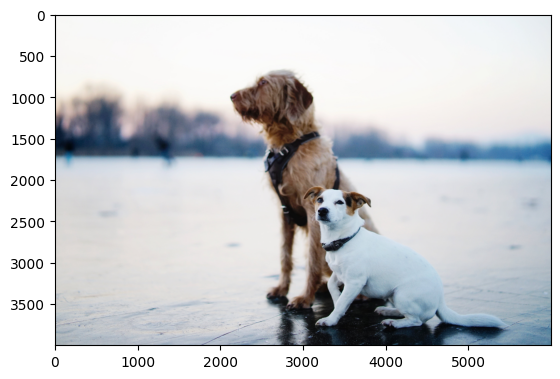

In [34]:
plt.imshow(dogs_image_1[:, :, ::-1])
plt.show()

In [35]:
dogs_classifiation_results_1 = CLIENT.infer_from_workflow(
    specification=DETECTION_PLUS_CLASSIFICATION["specification"],
    images={"image": dogs_image_1},
)

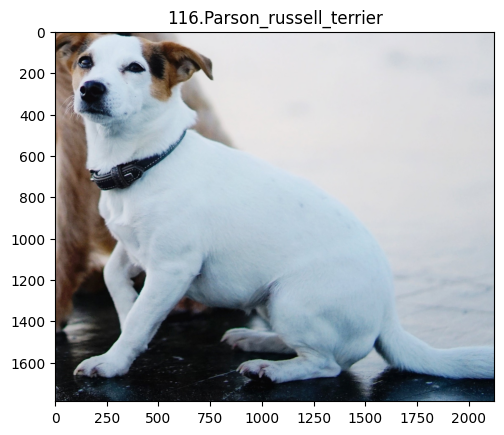

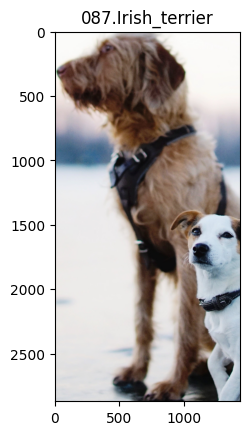

In [36]:
for prediction, crop in zip(dogs_classifiation_results_1["predictions"], dogs_classifiation_results_1["crops"]):
    plt.title(prediction)
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()

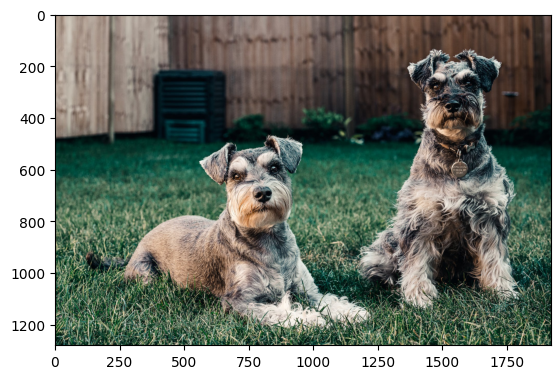

In [37]:
plt.imshow(dogs_image_2[:, :, ::-1])
plt.show()

In [38]:
dogs_classifiation_results_2 = CLIENT.infer_from_workflow(
    specification=DETECTION_PLUS_CLASSIFICATION["specification"],
    images={"image": dogs_image_2},
)

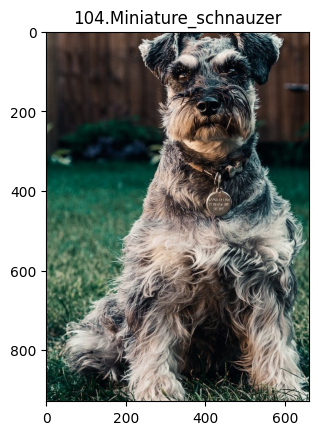

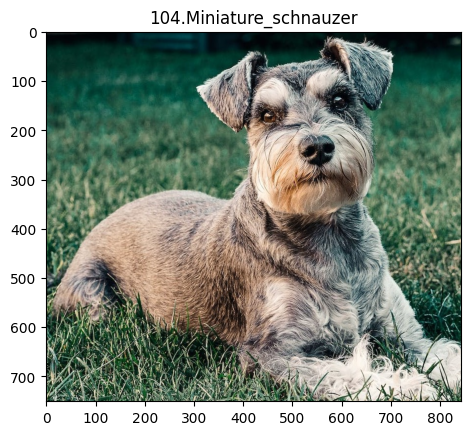

In [39]:
for prediction, crop in zip(dogs_classifiation_results_2["predictions"], dogs_classifiation_results_2["crops"]):
    plt.title(prediction)
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()

## Introduce Active Learning block

In this example, we present on how to introduce Active Learning data collection block to the workflow. You would need to have example object-detection project created in Roboflow app ([docs](https://docs.roboflow.com/datasets/create-a-project)).

In [40]:
YOUR_PROJECT_NAME = ... # place your project

In [42]:
ACTIVE_LEARNING_WORKFLOW = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",  # definition of object detection model - generic detection based on COCO classes
                "name": "general_detection",
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "yolov8n-640",  # pointing model to be used
                "disable_active_learning": True,  # we are disabling Active Learning for model 
                # (it is advised to do so, when ActiveLearningDataCollector is in use)
            },
            {
                "type": "ActiveLearningDataCollector",  # definition of data collector block
                "name": "active_learning_block",
                "image": "$inputs.image",  # we need to point image that is reference point for predictions
                "predictions": "$steps.general_detection.predictions",  # we need to point `predictions` output from detection model
                "target_dataset": YOUR_PROJECT_NAME,
                "active_learning_configuration": {  # this is standard AL data collection config - see: https://inference.roboflow.com/enterprise/active-learning/active_learning/
                    "enabled": True,
                    "persist_predictions": True,
                    "sampling_strategies": [
                        {
                            "type": "random",
                            "name": "a",
                            "traffic_percentage": 1.0,
                            "limits": [{"type": "daily", "value": 100}],
                        },
                    ],
                    "batching_strategy": {
                        "batches_name_prefix": "al_in_workflows",
                        "recreation_interval": "daily"
                    }
                }
            }
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.general_detection.predictions" },
        ]   
    }
}

In [43]:
al_results = CLIENT.infer_from_workflow(
    specification=ACTIVE_LEARNING_WORKFLOW["specification"],
    images={"image": multiple_cars_image_2},
)

In [44]:
al_results

{'predictions': [[{'x': 2363.5,
    'y': 3634.0,
    'width': 1283.0,
    'height': 840.0,
    'confidence': 0.8711808919906616,
    'class': 'car',
    'class_id': 2,
    'detection_id': '8c5602f6-1c76-4d92-a729-db3a38cc9061',
    'parent_id': '$inputs.image'},
   {'x': 3205.5,
    'y': 3682.0,
    'width': 493.0,
    'height': 746.0,
    'confidence': 0.7880513668060303,
    'class': 'car',
    'class_id': 2,
    'detection_id': 'ef9482d0-de3d-425e-a406-0a2018c03166',
    'parent_id': '$inputs.image'},
   {'x': 1026.5,
    'y': 3615.0,
    'width': 1197.0,
    'height': 914.0,
    'confidence': 0.7465572953224182,
    'class': 'car',
    'class_id': 2,
    'detection_id': '7eaeefd0-1b31-4346-80c0-713f6fd7f44c',
    'parent_id': '$inputs.image'}]]}

## Yolo World - do not train, just detect!
We've brought [Yolo World](https://blog.roboflow.com/what-is-yolo-world/) model into the `workflows` world! From `inference==0.9.13` you can use it as any other object detection
block! You can parametrise set of classes and detect different objects in the image!

In [18]:
YOLO_WORLD = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },   # definition of input image
            { "type": "InferenceParameter", "name": "class_names" },   # definition of class names
            { "type": "InferenceParameter", "name": "confidence", "default_value": 0.3 },   # definition of confidence
        ],
        "steps": [
            {
                "type": "YoloWorld", # definition of object detection model - Yolo World 
                "name": "general_detection",
                "image": "$inputs.image",
                "class_names": "$inputs.class_names",
                "confidence": "$inputs.confidence",
            },
            {
                "type": "Crop",  # we would like to run specialised classification of dog breed based on each detected `dog` bounding box
                "name": "cropping",
                "image": "$inputs.image",  # linking input image into detection model
                "detections": "$steps.general_detection.predictions",  # we need to point detections that will be used to crop image
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.general_detection.predictions" },  # output with detection prediction
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" }  # crops that were made based on dogs detections - used here just to ease visualisation
        ]   
    }
}

In [19]:
cars_image = cv2.imread("./images/multiple_cars_2.jpg")

In [29]:
yolo_world_results_1 = CLIENT.infer_from_workflow(
    specification=YOLO_WORLD["specification"],
    images={"image": cars_image},
    parameters={
        "class_names": ["car"],
        "confidence": 0.6,
    }
)

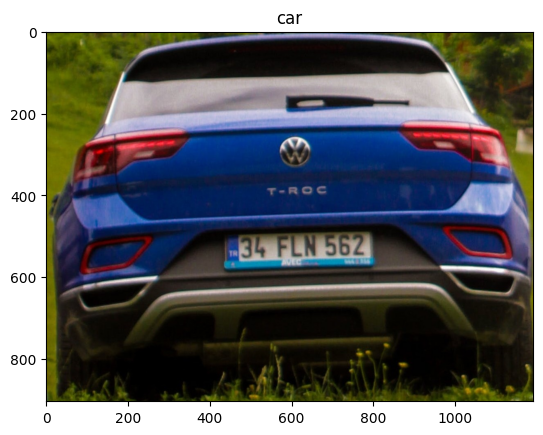

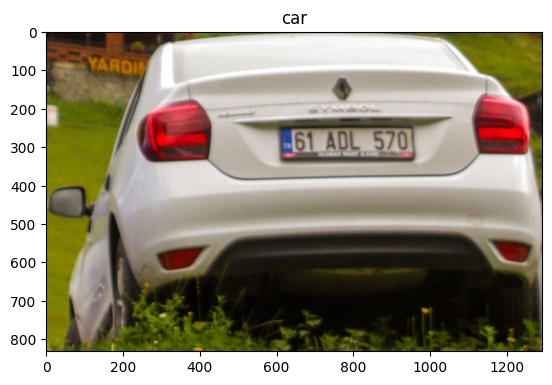

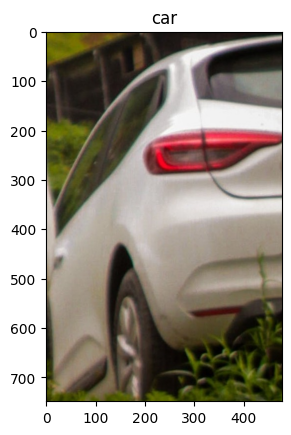

In [30]:
for prediction, crop in zip(yolo_world_results_1["predictions"][0], yolo_world_results_1["crops"]):
    plt.title(prediction["class_name"])
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()

## Yolo World model - easily combine new foundation model with other `workflows` blocks!

You can easily combine `YoloWorld` step with other steps that other steps.

In this example - we show slightly twisted example of detection+classification `workflow`, but instead of COCO-trained model, we use Yolo World!

In [7]:
DETECTION_PLUS_CLASSIFICATION_YOLO_WORLD = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },   # definition of input image
        ],
        "steps": [
            {
                "type": "YoloWorld", # definition of object detection model - Yolo World 
                "name": "general_detection",
                "image": "$inputs.image",
                "class_names": ["dog"],
                "confidence": 0.3,
            },
            {
                "type": "Crop",  # we would like to run specialised classification of dog breed based on each detected `dog` bounding box
                "name": "cropping",
                "image": "$inputs.image",  # linking input image into detection model
                "detections": "$steps.general_detection.predictions",  # we need to point detections that will be used to crop image
            },    
            {
                "type": "ClassificationModel",  # definition of classification model - specialised classifier of dogs breed
                "name": "breds_classification",
                "image": "$steps.cropping.crops",  # linking crops created based on dogs bounding boxes as input for classification
                "model_id": "dog-breed-xpaq6/1",  # pointing model to be used
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "predictions", "selector": "$steps.breds_classification.top" },  # output with classification prediction
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" },  # crops that were made based on dogs detections - used here just to ease visualisation
        ]   
    }
}

In [8]:
dogs_image_1 = cv2.imread("./images/dogs_1.jpg")

In [9]:
yolo_world_results = CLIENT.infer_from_workflow(
    specification=DETECTION_PLUS_CLASSIFICATION_YOLO_WORLD["specification"],
    images={"image": dogs_image_1},
)

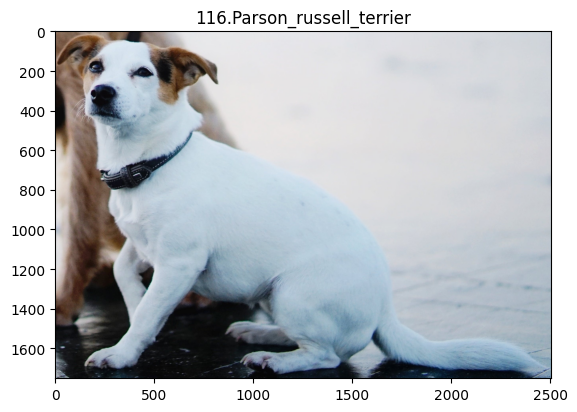

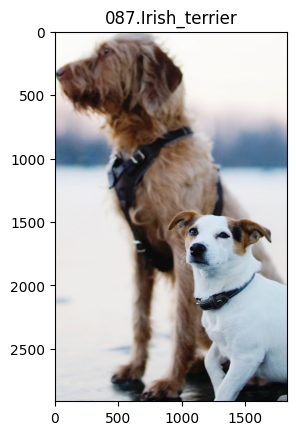

In [10]:
for prediction, crop in zip(yolo_world_results["predictions"], yolo_world_results["crops"]):
    plt.title(prediction)
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()

## Welcome Large Multimodal Models into `workflows`

### Unconstrained prompting of GPT-4V

In this example we demonstrate how GPT-4V may be used to produce great results withn `workflows`. In few examples, we will demonstrate hoe to
employ this powerful model to work, such that you can build powerful applications without single line of code!


**IMPORTANT NOTE:** We do not only support GPT-4V, but also Cog-VLM model - to use this model:
* run `inference server start --dev` on machine with GPU (we requrie at least T4 with 15G of VRAM to fit the model)
* set `lmm_type=cog_vlm` in LMM* steps' definitions
* do not provide OpenAI API key

In [17]:
import getpass

OPEN_AI_API_KEY = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


In [12]:
multiple_cars_image_2 = cv2.imread("./images/multiple_cars_2.jpg")
multiple_cars_image_3 = cv2.imread("./images/multiple_cars_3.jpg")

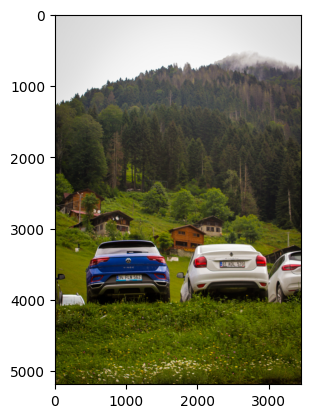

In [13]:
plt.imshow(multiple_cars_image_2[:, :, ::-1])
plt.show()

In [39]:
FLEXIBLE_LLM_SPECIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },
            { "type": "InferenceParameter", "name": "open_ai_key" },
            { "type": "InferenceParameter", "name": "lmm_type" },
            { "type": "InferenceParameter", "name": "prompt" },
            { "type": "InferenceParameter", "name": "expected_output"},
        ],
        "steps": [     
            {
                "type": "LMM",  # Type of new block allowing LMM prompting
                "name": "step_1",
                "image": "$inputs.image",  # Image is injected as LMM input
                "lmm_type": "$inputs.lmm_type",  # type of LMM is selected - `gpt_4v` or `cog_vlm` to be used
                "prompt": "$inputs.prompt",  # any arbitraty text prompt can be injected here
                "json_output": "$inputs.expected_output",  # if this parameter is given - it holds definition of JSON output that LMM is suppose to fill
                "remote_api_key": "$inputs.open_ai_key",  # API key
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "structured_output", "selector": "$steps.step_1.structured_output" },
        ]   
    }
}

#### Image captioning

We can ask GPT to produce caption for image given

In [30]:
response = CLIENT.infer_from_workflow(
    specification=FLEXIBLE_LLM_SPECIFICATION["specification"],
    images={
        "image": multiple_cars_image_2,
    },
    parameters={
        "open_ai_key": OPEN_AI_API_KEY,
        "lmm_type": "gpt_4v",
        "prompt": "Provide a meaningful description for the image given, including context and visible objects.",
        "expected_output": {
            "description": "This is the field to inject produced description",
        }
    }
)

In [37]:
response["structured_output"][0]["description"]

"The image features a rural landscape with a hillside covered by a dense forest. Partially obscured by a grassy field dotted with wildflowers, there are several vehicles parked in the foreground. A blue SUV with a visible license plate reading '34 FLN 562' and a white car with a license plate '61 ADL 570' are the most prominent. Small houses or cabins with traditional architecture are nestled on the hillside, contributing to a serene and picturesque setting. The sky is overcast, suggesting it could be a cool or damp day in a mountainous region."

### Detection of emergency

We can easily turn `workflows` into emergency situation detector

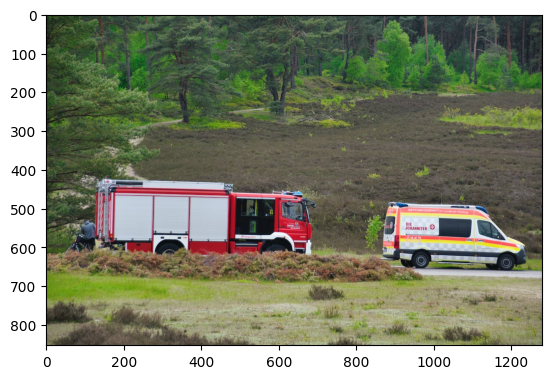

In [40]:
plt.imshow(multiple_cars_image_3[:, :, ::-1])
plt.show()

In [41]:
response = CLIENT.infer_from_workflow(
    specification=FLEXIBLE_LLM_SPECIFICATION["specification"],
    images={
        "image": multiple_cars_image_3,
    },
    parameters={
        "open_ai_key": OPEN_AI_API_KEY,
        "lmm_type": "gpt_4v",
        "prompt": "You are an expert in detecting emergency situation. Tell if the image given shows an emergency situation.",
        "expected_output": {
            "emergency": "Boolean flag with values: true / false with your response",
        }
    }
)

In [42]:
response["structured_output"][0]["emergency"]

True

### Objects counting

We can easily make the `workflow` that counts visible objects

In [43]:
response = CLIENT.infer_from_workflow(
    specification=FLEXIBLE_LLM_SPECIFICATION["specification"],
    images={
        "image": multiple_cars_image_3,
    },
    parameters={
        "open_ai_key": OPEN_AI_API_KEY,
        "lmm_type": "gpt_4v",
        "prompt": "Your task is to count an object of given class in the input image",
        "expected_output": {
            "counts": "List of tuples in format [object_type, count]",
        }
    }
)

In [44]:
response["structured_output"][0]["counts"]

[['fire_truck', 1], ['ambulance', 1]]

### LMM as classifier

In the previous example we shown that LLM block can be used in multple use-cases, but we've not shown how to combine `LMM*` blocks with other workflow
elements. We are going to present this capability here. We will re-use one of the previous example to showase detection+classification workflow, 
this time, with `LMMForClassification` block.

In [57]:
YOLO_WORLD_DETECTION_GPT_CLASSIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },
            { "type": "InferenceParameter", "name": "detection_classes" },
            { "type": "InferenceParameter", "name": "classifiction_classes" },
            { "type": "InferenceParameter", "name": "open_ai_key" },
            { "type": "InferenceParameter", "name": "lmm_type" },
        ],
        "steps": [
            {
                "type": "YoloWorld",
                "name": "step_1",
                "image": "$inputs.image",
                "class_names": "$inputs.detection_classes",
                "confidence": 0.005,
            },
            {
                "type": "Crop",
                "name": "step_2",
                "image": "$inputs.image",
                "detections": "$steps.step_1.predictions"
            },
            {
                "type": "LMMForClassification",
                "name": "step_3",
                "image": "$steps.step_2.crops",
                "lmm_type": "$inputs.lmm_type",
                "classes": "$inputs.classifiction_classes",
                "remote_api_key": "$inputs.open_ai_key",
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "detections", "selector": "$steps.step_1.*" },
            { "type": "JsonField", "name": "crops", "selector": "$steps.step_2.crops" },
            { "type": "JsonField", "name": "llm_output", "selector": "$steps.step_3.*" },
            { "type": "JsonField", "name": "top", "selector": "$steps.step_3.top" },
        ]   
    }
}

In [58]:
multiple_cars_image_1 = cv2.imread("./images/multiple_cars_1.jpg")

In [59]:
response = CLIENT.infer_from_workflow(
    specification=YOLO_WORLD_DETECTION_GPT_CLASSIFICATION["specification"],
    images={
        "image": multiple_cars_image_1,
    },
    parameters={
        "open_ai_key": OPEN_AI_API_KEY,
        "lmm_type": "gpt_4v",
        "detection_classes": ["car"],
        "classifiction_classes": ["Lexus", "Honda", "Seat"],
    }
)

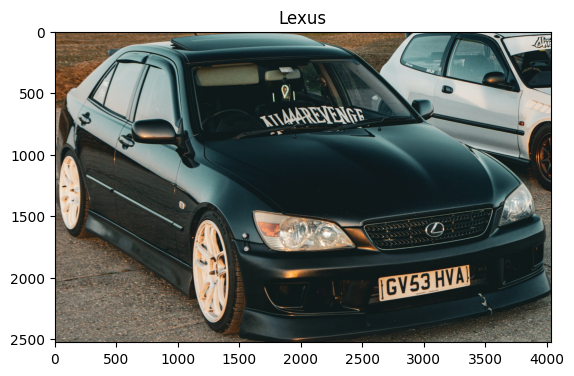

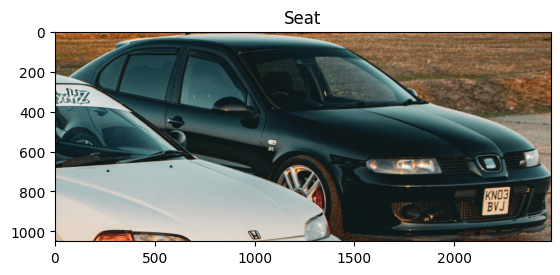

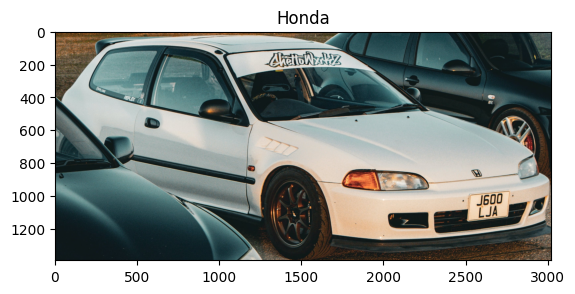

In [62]:
for prediction, crop in zip(response["top"], response["crops"]):
    plt.title(prediction)
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()

### LMM model as OCR

In this example, we will use LMM model as a replacement for OCR model in a `workflow` to read licence plates.

In [63]:
READING_PLATES_SPECIFICATION = {
    "specification": {
        "version": "1.0",
        "inputs": [
            { "type": "InferenceImage", "name": "image" },
            { "type": "InferenceParameter", "name": "open_ai_key" },
            { "type": "InferenceParameter", "name": "lmm_type" },
        ],
        "steps": [
            {
                "type": "ObjectDetectionModel",   # definition of object detection model
                "name": "plates_detector",  
                "image": "$inputs.image",  # linking input image into detection model
                "model_id": "vehicle-registration-plates-trudk/2",  # pointing model to be used
            },
            {
                "type": "Crop",   # we would like to run OCR against each and every plate detected - hece we are cropping inputr image using offseted predictions
                "name": "cropping",
                "image": "$inputs.image",  # we need to point image to crop
                "detections": "$steps.plates_detector.predictions",  # we need to point detections that will be used to crop image (in this case - we use offseted prediction)
            },        
            {
                "type": "LMM",
                "name": "step_3",
                "image": "$steps.cropping.crops",
                "lmm_type": "$inputs.lmm_type",
                "prompt": "You are responsible for helping people that struggle to read with text reading.",
                "json_output": {
                    "licence_plate": "This field must hold recognised text"
                },
                "remote_api_key": "$inputs.open_ai_key",
            },
        ],
        "outputs": [
            { "type": "JsonField", "name": "recognised_plates", "selector": "$steps.step_3.licence_plate" },  # notice that json_output was translated into registered step output!
            { "type": "JsonField", "name": "crops", "selector": "$steps.cropping.crops" },  # crops that were made based on plates detections - used here just to ease visualisation
        ]   
    }
}

In [64]:
response = CLIENT.infer_from_workflow(
    specification=READING_PLATES_SPECIFICATION["specification"],
    images={
        "image": multiple_cars_image_1,
    },
    parameters={
        "open_ai_key": OPEN_AI_API_KEY,
        "lmm_type": "gpt_4v"
    }
)

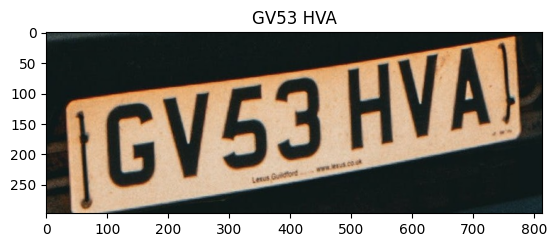

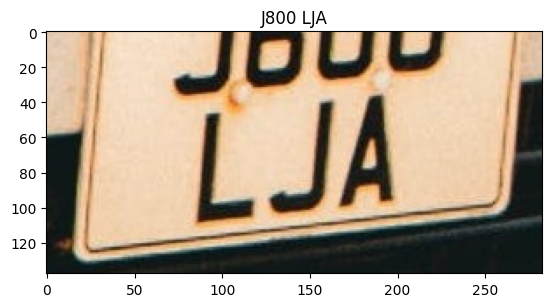

In [67]:
for prediction, crop in zip(response["recognised_plates"], response["crops"]):
    plt.title(prediction)
    plt.imshow(crop["value"][:, :, ::-1])
    plt.show()